In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from queue import deque
import json
import os
import sys

In [2]:
def export_graph(theGraph, distances, path_dir):
    data_graph = nx.json_graph.node_link_data(theGraph)
    data_distances = distances.tolist()
    data = {
        'distances': data_distances,
        'graph': data_graph
    }

    with open(path_dir, 'w+') as outfile:  
        json.dump(data, outfile)

def import_graph(path_dir):
    with open(path_dir) as json_file:
        data = json.load(json_file)
        print(data['distances'])
        #print(data['graph'])
        graph = nx.json_graph.node_link_graph(data['graph'])
        return graph, data['distances']

In [3]:
def plot_graph(theGraph):
    nx.draw(theGraph)
    plt.subplot(121)
    nx.draw(theGraph, with_labels=True)
    plt.show()

In [56]:
def mount_graph():
    
    theGraph = nx.DiGraph()   #Pe, El, En, Ca, Pi : Pedreiro/Eletricista/Encanador/Carpinteiro/Pintor 
       
    #Build 01 - Local A - 5 teams
    theGraph.add_node('Pb1',id=1, local='B', time=1, team='pedreiro', build='1')
    theGraph.add_node('Pa1',id=1, local='A', time=1, team='pedreiro', build='1')
    theGraph.add_node('En1',id=1, local='A', time=1, team='encanador', build='1')
    
    
    #Build 01 - Edges:
    theGraph.add_edge('Pa1','En1')

    distances = np.zeros((2,2), dtype=int) # matriz 10x10 e diagonal principal preenchida com Zeros
    distances[:] = 1
    return theGraph, distances

In [5]:
def topological_sort(theGraph):
    
    topSort = []
    q = deque() 

    for edge in theGraph.in_degree:
        if edge[1] == 0:
            q.appendleft(edge[0])
    
    while q:
        node = q.pop()
        topSort.append(node)
        for adj in theGraph.adj[node]:
            if adj not in q:
                q.appendleft(adj)
    
    return topSort

In [6]:
def show_schedule(schedules, order):
    print('ordenação topologica:')
    print(order, '\n')
    print('matriz de schedules:')
    
    for i in range(len(schedules)):
        print('dia:', i+1)
        for activity in schedules[i]:
            if 'deslocamento' in activity:
                print('\t', activity)
            else:
                print('\t', activity, theGraph.nodes[activity]['local'], theGraph.nodes[activity]['team'])

In [104]:
def define_work_period(theGraph, pos, teams):
    
    current_node = theGraph.nodes[pos]
    day = 0
    previous_day = 0
    for previous in theGraph.pred[pos]:
        if not theGraph.nodes[previous]['scheduled']:
            define_work_period(theGraph, previous, teams)
        previous_day = theGraph.nodes[previous]['time'] + theGraph.nodes[previous]['day']
        if previous_day > day:
            day = previous_day
    team = teams[theGraph.nodes[pos]['team']]
    #print('team:', theGraph.nodes[pos]['team'], team)
    #print(team['schedules'], len(team['schedules']))
    
    #if len(team['schedules']) == 0:
        #team['schedules'].update( {day : theGraph.nodes[pos]['local']})
    previous_local = None
    
    if len(team['schedules']) > 0:
        last = sorted(team['schedules'].keys())[-1]
        #print('**********', last, team['schedules'][last])
        if day in team['schedules']:
            while day in team['schedules']:
                scheduled = team['schedules'][day]
                if 'deslocamento' not in scheduled:
                    previous_local = theGraph.nodes[team['schedules'][day]]['local']
                day += 1
        elif last in team['schedules']:
            previous_local = theGraph.nodes[team['schedules'][last]]['local']
            day = last + 1

        if previous_local != theGraph.nodes[pos]['local']:
            #print('deslocamento', theGraph.nodes[pos]['team'], previous_local, theGraph.nodes[pos]['local'])
            deslocamento = 'deslocamento: ' + theGraph.nodes[pos]['team'] +" "+ previous_local +" -> "+ theGraph.nodes[pos]['local']
            
            team['schedules'].update( {day : deslocamento})
            day += 1
    team['schedules'].update({day : pos})
    #print(day)
        
    #if team['local'] != theGraph.nodes[pos]['team']:
        #theGraph.nodes[pos]['local'] = team['local']
        #day += 1
    theGraph.nodes[pos]['day'] = day
    theGraph.nodes[pos]['scheduled'] = True 
    
    #print(theGraph.nodes[pos])
    #team['schedules'].update( {day : theGraph.nodes[pos]['team']})
    #print('----------------------')
    return day
    

def generate_wsrp_matrix(theGraph, order):
    n_nodes = len(theGraph)
    teams = {}
    for i in range(n_nodes):
        node = theGraph.nodes[order[i]]
        #print(node)
        teams.update({node['team']: {'quantity': 1, 'schedules':{}}})
        node['scheduled'] = False
        node['day'] = 0

    #for team in teams:
    #    print(team, teams[team])
        
    #schedules = []
    #day = []
    #working = []
    day = 0
    for i in range(n_nodes):
        #print('--------------------')
        #print(theGraph.nodes[order[i]])
        current_day = define_work_period(theGraph, order[i], teams)
        if current_day > day:
            day = current_day
    
    return day+1, teams

In [90]:
def mount_schedules(theGraph, teams, days):
    schedules = []
    n_nodes = len(theGraph)
    
    for i in range(days):
        schedules.append([])
    
    for team in teams:
        for schedule in teams[team]['schedules']:
            #print(teams[team]['schedules'][schedule], schedule)
            schedules[schedule].append(teams[team]['schedules'][schedule])

    return schedules

In [57]:
#train_csv = os.path.join(os.path.dirname(notebook_path), "Datasets/train.csv")
theGraph, distances = mount_graph()
export_graph(theGraph, distances, "/home/elvio/github/wsrp/graphs/exemplo7.txt")

[[1, 1], [1, 1]]


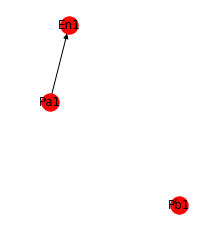

In [191]:
theGraph, distances = import_graph("/home/elvio/github/wsrp/graphs/exemplo7.txt")
plot_graph(theGraph)

In [192]:
order = topological_sort(theGraph)
n_nodes = len(theGraph)
print(n_nodes, order)
for i in range(n_nodes):
    node = theGraph.nodes[order[i]]
    print(order[i], node)

3 ['Pb1', 'Pa1', 'En1']
Pb1 {'local': 'B', 'time': 1, 'team': 'pedreiro', 'build': '1'}
Pa1 {'local': 'A', 'time': 1, 'team': 'pedreiro', 'build': '1'}
En1 {'local': 'A', 'time': 1, 'team': 'encanador', 'build': '1'}


In [193]:
days, teams = generate_wsrp_matrix(theGraph, order)
schedules = mount_schedules(theGraph, teams, days)
print(schedules)
show_schedule(schedules, order)

print(n_nodes, order)
print('n de dias', days)
for i in range(n_nodes):
    node = theGraph.nodes[order[i]]
    print(order[i], node)

for team in teams:
    #print(teams[team]['schedules'])
    print(teams[team])

[['Pb1'], ['deslocamento: pedreiro B -> A'], ['Pa1'], ['En1']]
ordenação topologica:
['Pb1', 'Pa1', 'En1'] 

matriz de schedules:
dia: 1
	 Pb1 B pedreiro
dia: 2
	 deslocamento: pedreiro B -> A
dia: 3
	 Pa1 A pedreiro
dia: 4
	 En1 A encanador
3 ['Pb1', 'Pa1', 'En1']
n de dias 4
Pb1 {'local': 'B', 'time': 1, 'team': 'pedreiro', 'build': '1', 'scheduled': True, 'day': 0}
Pa1 {'local': 'A', 'time': 1, 'team': 'pedreiro', 'build': '1', 'scheduled': True, 'day': 2}
En1 {'local': 'A', 'time': 1, 'team': 'encanador', 'build': '1', 'scheduled': True, 'day': 3}
{'quantity': 1, 'schedules': {0: 'Pb1', 1: 'deslocamento: pedreiro B -> A', 2: 'Pa1'}}
{'quantity': 1, 'schedules': {3: 'En1'}}


In [194]:
def is_order_valid(theGraph, order):
    n_nodes = len(order)
    
    for i in range(n_nodes):
        pos = order[i]
        for previous in theGraph.pred[pos]:
            p_index = order.index(previous)
            if p_index > i:
                return False
    return True
    
def tabu_search(theGraph, order):
    iterations = 15
    top_candidates = 20
    penalizations = 3
    
    best_fit, _ = generate_wsrp_matrix(theGraph, order)
    best_order = order
    best_fit_total = best_fit
    best_order_total = order
    #print('best:', best_fit, best_order)
    
    tabu_structure = []
    n_nodes = len(order)
    for i in range(n_nodes):
        tabu_structure.append([0] * n_nodes)
        #print(tabu_structure[i])
    
    candidates = {}
    has_better = True
    current_iteration = 0
    
    while current_iteration < iterations and has_better: 
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):
                current_order = best_order.copy()
                element_aux = current_order[i]
                current_order[i] = current_order[j]
                current_order[j] = element_aux

                is_valid = is_order_valid(theGraph, current_order)

                if is_valid:
                    fit, _ = generate_wsrp_matrix(theGraph, current_order)
                    diff = best_fit - fit
                    key = "{} {}".format(current_order[i], current_order[j])
                    candidates.update({key: [diff, fit, i, j, current_order]})
                    #print(is_valid, best_fit, fit, diff, i, j, current_order[j], current_order[i])
                    #print(best_order)
                    #print(current_order)
        
    
        #print(candidates)
        #for k, v in candidates.items():
        #    print(k, v)
        ordered_candidates = [(k, candidates[k]) for k in sorted(candidates, key=candidates.get, reverse=True)]
        len_candidates = len(ordered_candidates)
        if len_candidates > top_candidates:
            len_candidates = top_candidates
        
        #print('ordered:')
        has_better = False
        for i in range(len_candidates):
            candidate = ordered_candidates[i]
            diff = candidate[1][0]
            value = candidate[1][1]
            tabu = tabu_structure[candidate[1][2]][candidate[1][3]]
            
            #print(candidate)
            #print(i, candidate[1][0], candidate[1][1], candidate[1][2], candidate[1][3], tabu)
            
            tabu_structure[candidate[1][3]][candidate[1][2]] = tabu_structure[candidate[1][3]][candidate[1][2]] + 1
            if tabu == 0 or value < best_fit_total:
                has_better = True
                tabu_structure[candidate[1][2]][candidate[1][3]] = penalizations + 1
                if value < best_fit_total:
                    best_fit_total = value
                    best_order_total = candidate[1][4]
                if value < best_fit:
                    best_fit = value
                    best_order = candidate[1][4]
                
        for i in range(n_nodes):
            for j in range(i+1, n_nodes):
                if tabu_structure[i][j] > 0:
                    tabu_structure[i][j] -= 1
        #print('ordered:', ordered_candidates)
        #print('candidates:', candidates)
        #print('best:', days, order)
        
        #for i in range(n_nodes):
        #    print(tabu_structure[i])
        
        current_iteration += 1
    return best_fit_total, best_order_total

fit, order = tabu_search(theGraph, order)
print(fit, order)

days, teams = generate_wsrp_matrix(theGraph, order)
schedules = mount_schedules(theGraph, teams, days)
print(schedules)
show_schedule(schedules, order)
#['Pb1', 'Pa1', 'En1']

3 ['Pa1', 'Pb1', 'En1']
[['Pa1'], ['deslocamento: pedreiro A -> B', 'En1'], ['Pb1']]
ordenação topologica:
['Pa1', 'Pb1', 'En1'] 

matriz de schedules:
dia: 1
	 Pa1 A pedreiro
dia: 2
	 deslocamento: pedreiro A -> B
	 En1 A encanador
dia: 3
	 Pb1 B pedreiro
